In [1]:
import numpy as np
import matplotlib.pyplot as plt

#ntrain = 1100
#mu, d, u = np.load("bc_tot1.npy"), np.load("dist_tot1.npy"), np.load("u_tot1.npy")

#ntrain = 1750
#mu, d, u = np.load("bc_tot2.npy"), np.load("dist_tot2.npy"), np.load("u_tot2.npy")

ntrain=1100
mu, d, u=np.load("bc10_new.npy"), np.load("d10_new.npy"), np.load("u10_new.npy")

In [2]:
def permutation(n, mu, d, u):
    perm = np.random.permutation(n)
    scale = 1
    return scale*mu[perm], scale*d[perm], scale*u[perm]

mu, d, u = permutation(mu.shape[0], mu, d, u)

In [3]:
from scipy.linalg import svd

A, s, Bt = svd(u[:ntrain].T, full_matrices = False) # POD computed via Singular Value Decomposition (SVD)

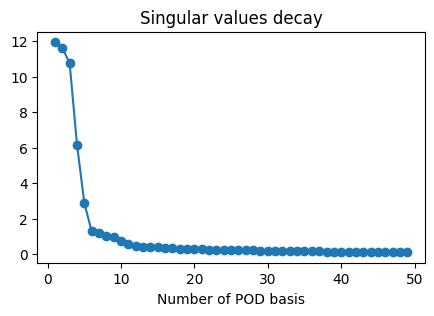

In [4]:
plt.figure(figsize = (5, 3))
plt.plot(np.arange(1, 50), s[1:50], '-o')
plt.title('Singular values decay')
plt.xlabel("Number of POD basis")
plt.show()

In [5]:
n = 40
#n=20
V = A[:, :n]

In [6]:
from dlroms.cores import CPU # switch to GPU if needed
mu = CPU.tensor(mu)
d = CPU.tensor(d)
u = CPU.tensor(u)
V = CPU.tensor(V)

In [7]:
from dlroms.roms import mrei, mre, mse, euclidean, num2p
error = mrei(euclidean)
error

<function dlroms.roms.<lambda>.<locals>.<lambda>(utrue, upred)>

In [8]:
uproj = V @ (V.T @ u.T)
uproj = uproj.T
uproj.shape

torch.Size([1512, 9261])

In [9]:
print("Average projection error (relative): %.3e." % error(u[ntrain:], uproj[ntrain:]))

Average projection error (relative): 2.774e-03.


In [10]:
from dlroms.dnns import Dense, Reshape
from dlroms.minns import Local
from podminn import tanh

# Dense network mapping physical (macro) parameters onto a feature vector of length p

#!!!!!!!!!!!!!!!!!RETE PER BOUND COND??????????????????????
p = 10
phi = Dense(mu.shape[1], 20, activation = tanh) + Dense(20, p, activation = None) + Reshape(p, 1)
#phi = Dense(mu.shape[1], 300, activation = tanh)+ Dense(300, 100, activation = tanh) + Dense(100, p, activation = None) + Reshape(p, 1)




In [11]:
from np2vtk import Slab

In [12]:
# Auxiliary coarse mesh for Mesh-Informed layers
xfine = np.load("coordinates.npy")
#xcoarse = Slab(nx = 10, ny = 10, nz = 10, xL = 1, yL = 1, zL = 1).coordinates()
xcoarse = Slab(nx = 5, ny = 5, nz = 5, xL = 1, yL = 1, zL = 1).coordinates()
ncoarse = len(xcoarse)
#xcc=Slab(nx = 5, ny = 5, nz = 5, xL = 1, yL = 1, zL = 1).coordinates()
#ncc=len(xcc)

# Mesh-Informed neural network mapping geometric (micro) parameters onto feature matrix n x p
psi = Local(xfine, xcoarse, activation = tanh, support = 0.1) + Dense(ncoarse, n*p, activation = None) + Reshape(n, p)
#psi = Local(xfine, xcoarse, activation = tanh, support = 0.1) +Local(xcoarse, xcc, activation = tanh, support = 0.01)+ Dense(ncc, n*p, activation = None) + Reshape(n, p)

In [13]:
phi.Xavier() 
psi.Xavier()
print(phi.dof())
print(psi.dof())
print(phi(mu).shape)
print(psi(d).shape)


48270
91640
torch.Size([1512, 10, 1])
torch.Size([1512, 40, 10])


In [14]:
from podminn import PODMINN
rom = PODMINN(phi, psi, V = V, trainable = True)

In [15]:
c = (V.T @ u.T).T # POD coefficients (what the network should predict)

In [16]:

rom.train((mu, d), c, ntrain = ntrain, loss = mse(euclidean), epochs = 500, refresh=False)

		Train		Test
Epoch 1:	4.82e-01	4.75e-01.

>> ETA: N/D.
		Train		Test
Epoch 2:	3.68e-01	3.64e-01.

>> ETA: 8m 51.21s.
		Train		Test
Epoch 3:	1.55e-01	1.40e-01.

>> ETA: 8m 56.03s.
		Train		Test
Epoch 4:	4.15e-02	3.46e-02.

>> ETA: 8m 56.95s.
		Train		Test
Epoch 5:	3.22e-02	2.65e-02.

>> ETA: 8m 59.76s.
		Train		Test
Epoch 6:	2.78e-02	2.31e-02.

>> ETA: 9m 4.80s.
		Train		Test
Epoch 7:	2.55e-02	2.16e-02.

>> ETA: 9m 12.85s.
		Train		Test
Epoch 8:	2.36e-02	2.04e-02.

>> ETA: 9m 19.07s.
		Train		Test
Epoch 9:	2.19e-02	1.91e-02.

>> ETA: 9m 21.38s.
		Train		Test
Epoch 10:	2.03e-02	1.82e-02.

>> ETA: 9m 24.66s.
		Train		Test
Epoch 11:	1.87e-02	1.71e-02.

>> ETA: 9m 26.45s.
		Train		Test
Epoch 12:	1.83e-02	1.68e-02.

>> ETA: 9m 27.07s.
		Train		Test
Epoch 13:	1.79e-02	1.65e-02.

>> ETA: 9m 26.90s.
		Train		Test
Epoch 14:	1.76e-02	1.62e-02.

>> ETA: 9m 27.34s.
		Train		Test
Epoch 15:	1.74e-02	1.60e-02.

>> ETA: 9m 27.95s.
		Train		Test
Epoch 16:	1.72e-02	1.57e-02.

>> ETA: 9m 27.75s.
		Train	

In [17]:
rom.freeze()
uROM = rom(mu, d) # ROM predictions
uROM.shape

torch.Size([1512, 9261])

In [ ]:
(V @ (uROM[ntrain:].T)).shape, u[ntrain:].shape

In [ ]:
print(("Average training ROM error: %.2f" % (100*error(u[:ntrain], (V @ (uROM[:ntrain].T)).T))) + "%.")
print(("Average testing ROM error: %.2f" % (100*error(u[ntrain:], (V @ (uROM[ntrain:].T)).T))) + "%.")


In [18]:
print(("Average ROM error: %.2f" % (100*error(u[ntrain:], uROM[ntrain:]))) + "%.")

Average ROM error: 0.76%.


In [19]:
np.savez('./dati10.npz', mu = mu.cpu().numpy(), d = d.cpu().numpy(), u = u.cpu().numpy())
np.save('./V10.npy', V.cpu().numpy())
phi.save('./phi10')
psi.save('./psi10')

In [ ]:
dati = np.load('./dati.npz') #mu = dati['mu']
V = np.load('./V.npy') #dati e V da passare a tensori torch
phi.load('./phi.npz')
psi.load('./psi.npz')